## Programming exercises

### 11.1 The Gaussian Mixture Model and the EM algorithm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
#from toolbox_02450 import clusterplot
from sklearn.mixture import GaussianMixture

In [2]:
# Load Matlab data file and extract variables of interest
mat_data = loadmat('synth1.mat')
X = np.matrix(mat_data['X'])
y = np.matrix(mat_data['y'])
attributeNames = [name[0] for name in mat_data['attributeNames'].squeeze()]
classNames = [name[0][0] for name in mat_data['classNames']]
N, M = X.shape
C = len(classNames)
df=pd.DataFrame(X).set_axis(attributeNames,axis=1,inplace=False)
df["y"]=y
df.head()

,Attribute A,Attribute B,y
0,0.418193,0.725060,0
1,1.160776,1.253722,0
2,0.991951,0.573326,0
3,1.059111,1.143922,0
4,0.866616,1.143537,0


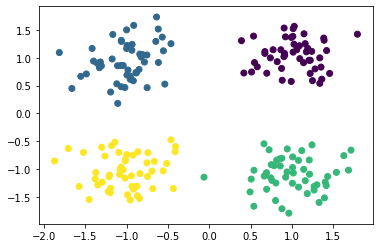

In [3]:
plt.scatter(x=df["Attribute A"],y=df["Attribute B"],c=df["y"]);


In [4]:
# Number of clusters
K = 4
cov_type = 'diag' ## or "full"      
# type of covariance, you can try out 'diag' as well
reps = 1                
# number of fits with different initalizations, best result will be kept
# Fit Gaussian mixture model
gmm = GaussianMixture(n_components=K, covariance_type=cov_type, n_init=reps)
gmm.fit(X)    

## Predict cluster for data
cls = gmm.predict(X)    
# Predict posterior probability of data under each Gaussian in the model
ppp = gmm.predict_proba(X)
   
# extract cluster means
cds = gmm.means_    
# extract cluster shapes (covariances of gaussians)
covs=gmm.covariances_
# extract the weights of each mixture components
wgh=gmm.weights_



In [5]:
if cov_type == 'diag':
    new_covs = np.zeros([K,M,M])    
count = 0
for elem in covs:
    temp_m = np.zeros([M,M])
    for i in range(len(elem)):
        temp_m[i][i] = elem[i]
        new_covs[count] = temp_m
    count += 1
    covs = new_covs

In [6]:
print(covs)

[[[0.12134889 0.        ]
  [0.         0.09046334]]

 [[0.08746956 0.        ]
  [0.         0.07519553]]

 [[0.08684606 0.        ]
  [0.         0.11656804]]

 [[0.09957385 0.        ]
  [0.         0.09273688]]]


**Function 1:** Cluster plot

In [20]:
def clusterplot(X, clusterid, centroids='None', y='None', covars='None'):
    '''
    CLUSTERPLOT Plots a clustering of a data set as well as the true class
    labels. If data is more than 2-dimensional it should be first projected
    onto the first two principal components. Data objects are plotted as a dot
    with a circle around. The color of the dot indicates the true class,
    and the cicle indicates the cluster index. Optionally, the centroids are
    plotted as filled-star markers, and ellipsoids corresponding to covariance
    matrices (e.g. for gaussian mixture models).

    Usage:
    clusterplot(X, clusterid)
    clusterplot(X, clusterid, centroids=c_matrix, y=y_matrix)
    clusterplot(X, clusterid, centroids=c_matrix, y=y_matrix, covars=c_tensor)
    
    Input:
    X           N-by-M data matrix (N data objects with M attributes)
    clusterid   N-by-1 vector of cluster indices
    centroids   K-by-M matrix of cluster centroids (optional)
    y           N-by-1 vector of true class labels (optional)
    covars      M-by-M-by-K tensor of covariance matrices (optional)
    '''
    
    X = np.asarray(X)
    cls = np.asarray(clusterid)
    if y=='None':
        y = np.zeros((X.shape[0],1))
    else:
        y = np.asarray(y)
    if centroids!='None':
        centroids = np.asarray(centroids)
    K = np.size(np.unique(cls))
    C = np.size(np.unique(y))
    ncolors = np.max([C,K])
    
    # plot data points color-coded by class, cluster markers and centroids
    #hold(True)
    colors = [0]*ncolors
    for color in range(ncolors):
        colors[color] = plt.cm.jet.__call__(color*255/(ncolors-1))[:3]
    for i,cs in enumerate(np.unique(y)):
        plt.plot(X[(y==cs).ravel(),0], X[(y==cs).ravel(),1], 'o', markeredgecolor='k', markerfacecolor=colors[i],markersize=6, zorder=2)
    for i,cr in enumerate(np.unique(cls)):
        plt.plot(X[(cls==cr).ravel(),0], X[(cls==cr).ravel(),1], 'o', markersize=12, markeredgecolor=colors[i], markerfacecolor='None', markeredgewidth=3, zorder=1)
    if centroids!='None':        
        for cd in range(centroids.shape[0]):
            plt.plot(centroids[cd,0], centroids[cd,1], '*', markersize=22, markeredgecolor='k', markerfacecolor=colors[cd], markeredgewidth=2, zorder=3)
    # plot cluster shapes:
    if covars!='None':
        for cd in range(centroids.shape[0]):
            x1, x2 = gauss_2d(centroids[cd],covars[cd,:,:])
            plt.plot(x1,x2,'-', color=colors[cd], linewidth=3, zorder=5)
    #hold(False)

    # create legend        
    legend_items = np.unique(y).tolist()+np.unique(cls).tolist()+np.unique(cls).tolist()
    for i in range(len(legend_items)):
        if i<C: legend_items[i] = 'Class: {0}'.format(legend_items[i]);
        elif i<C+K: legend_items[i] = 'Cluster: {0}'.format(legend_items[i]);
        else: legend_items[i] = 'Centroid: {0}'.format(legend_items[i]);
    plt.legend(legend_items, numpoints=1, markerscale=.75, prop={'size': 9})

    
    
def gauss_2d(centroid, ccov, std=2, points=100):
    ''' Returns two vectors representing slice through gaussian, cut at given standard deviation. '''
    mean = np.c_[centroid]; tt = np.c_[np.linspace(0, 2*np.pi, points)]
    x = np.cos(tt); y=np.sin(tt); ap = np.concatenate((x,y), axis=1).T
    d, v = np.linalg.eig(ccov); d = std * np.sqrt(np.diag(d))
    bp = np.dot(v, np.dot(d, ap)) + np.tile(mean, (1, ap.shape[1])) 
    return bp[0,:], bp[1,:]

C:\Users\Meghdad\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\Meghdad\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\Meghdad\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\Meghdad\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


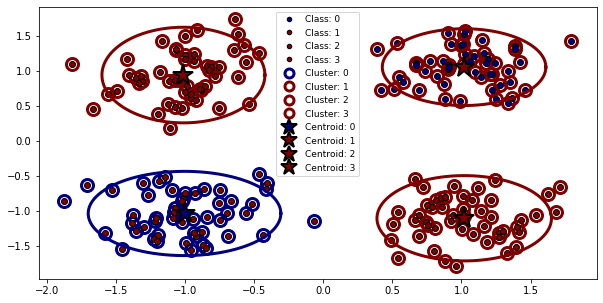

In [22]:
# Plot results:
plt.figure(figsize=(10,5))
clusterplot(X, clusterid=cls, centroids=cds, y=y, covars=covs);

### <font color='red'>Important:</font> 

`n_init` : int, defaults to 1.
The number of initializations to perform. The best results are kept. Each of the `n_init` initialisations will give a different result therefore the one with largest log likelihood can be chosen to carry out EM. By default GMM uses Kmean for initialisation.

#### AIC, BIC and Cross-validation

In [8]:
# Load Matlab data file and extract variables of interest
mat_data = loadmat('synth1.mat')
X = np.matrix(mat_data['X'])
y = np.matrix(mat_data['y'])
attributeNames = [name[0] for name in mat_data['attributeNames'].squeeze()]
classNames = [name[0][0] for name in mat_data['classNames']]
N, M = X.shape
C = len(classNames)
df=pd.DataFrame(X).set_axis(attributeNames,axis=1,inplace=False)
df["y"]=y
df.head()

,Attribute A,Attribute B,y
0,0.418193,0.725060,0
1,1.160776,1.253722,0
2,0.991951,0.573326,0
3,1.059111,1.143922,0
4,0.866616,1.143537,0


In [9]:
from sklearn.model_selection import KFold

In [16]:
## Example of the application of enumerate in Python
L = ['apples', 'bananas', 'oranges']
for idx, val in enumerate(L):
    print("index is %d and value is %s" % (idx, val))

index is 0 and value is apples
index is 1 and value is bananas
index is 2 and value is oranges


In [10]:
# Range of K's to try
KRange = range(1,11)
T = len(KRange)

covar_type = 'full'     # you can try out 'diag' as well
reps = 3                # number of fits with different initalizations, best result will be kept

# Allocate variables
BIC = np.zeros((T,1))
AIC = np.zeros((T,1))
CVE = np.zeros((T,1))

# K-fold crossvalidation
CV = KFold(10,shuffle=True)

for t,K in enumerate(KRange):
        print('Fitting model for K={0}\n'.format(K))

        # Fit Gaussian mixture model
        gmm = GaussianMixture(n_components=K, covariance_type=covar_type, n_init=reps)
        gmm.fit(X)

        # Get BIC and AIC
        BIC[t,0] = gmm.bic(X)
        AIC[t,0] = gmm.aic(X)

        # For each crossvalidation fold
        for train_index, test_index in CV.split(X):

            # extract training and test set for current CV fold
            X_train = X[train_index]
            X_test = X[test_index]

            # Fit Gaussian mixture model to X_train
            gmm = GaussianMixture(n_components=K, covariance_type=covar_type, n_init=reps)
            gmm.fit(X_train)

            # compute negative log likelihood of X_test
            CVE[t] += -gmm.score(X_test).sum()

Fitting model for K=1

Fitting model for K=2

Fitting model for K=3

Fitting model for K=4

Fitting model for K=5

Fitting model for K=6

Fitting model for K=7

Fitting model for K=8

Fitting model for K=9

Fitting model for K=10



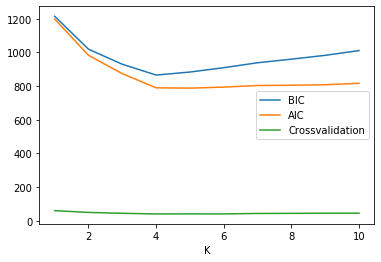

In [11]:
# Plot results
plt.plot(KRange, BIC)
plt.plot(KRange, AIC)
plt.plot(KRange, 2*CVE)
plt.legend(['BIC', 'AIC', 'Crossvalidation'])
plt.xlabel('K')
plt.show()

Use a Gaussian mixture model to cluster the Old Faithful data set, `faithful`, using AIC, BIC, or crossvalidation to select the number of clusters.

In [12]:
f = open("faithful.txt","r")
f=f.read()
f=f.split("\n")
x1=[]
x2=[]
for line in range(len(f)-1):
    x1.append(float(f[line].split()[0]))
    x2.append(float(f[line].split()[1]))
    
df=pd.DataFrame()
df["X1"]=x1
df["X2"]=x2
df.head()

,X1,X2
0,3.600,79.0
1,1.800,54.0
2,3.333,74.0
3,2.283,62.0
4,4.533,85.0


Fitting model for K=1

Fitting model for K=2

Fitting model for K=3

Fitting model for K=4

Fitting model for K=5

Fitting model for K=6

Fitting model for K=7

Fitting model for K=8

Fitting model for K=9

Fitting model for K=10



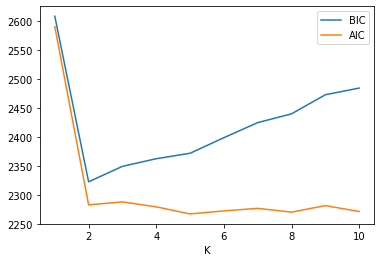

In [13]:
# Range of K's to try
KRange = range(1,11)
T = len(KRange)

covar_type = 'full'     # you can try out 'diag' as well
reps = 3                # number of fits with different initalizations, best result will be kept

# Allocate variables
BIC = np.zeros((T,1))
AIC = np.zeros((T,1))


# K-fold crossvalidation
CV = KFold(10,shuffle=True)

for t,K in enumerate(KRange):
        print('Fitting model for K={0}\n'.format(K))

        # Fit Gaussian mixture model
        gmm = GaussianMixture(n_components=K, covariance_type=covar_type, n_init=reps)
        gmm.fit(df)

        # Get BIC and AIC
        BIC[t,0] = gmm.bic(df)
        AIC[t,0] = gmm.aic(df)

        
        
# Plot results
plt.plot(KRange, BIC)
plt.plot(KRange, AIC)
plt.legend(['BIC', 'AIC'])
plt.xlabel('K')
plt.show()

Use a Gaussian mixture model to cluster the Iris data set,`iris.csv`, using AIC, BIC, or crossvalidation to select the number of clusters.

In [14]:
df=pd.read_csv("iris.csv")
df.head()
X=df.drop("Type",axis=1)
X.head()
X=X.values

In [15]:
# Range of K's to try
KRange = range(1,11)
T = len(KRange)

covar_type = 'full'     # you can try out 'diag' as well
reps = 3                # number of fits with different initalizations, best result will be kept

# Allocate variables
BIC = np.zeros((T,1))
AIC = np.zeros((T,1))
CVE = np.zeros((T,1))

# K-fold crossvalidation
CV = KFold(10,shuffle=True)

for t,K in enumerate(KRange):
        print('Fitting model for K={0}\n'.format(K))

        # Fit Gaussian mixture model
        gmm = GaussianMixture(n_components=K, covariance_type=covar_type, n_init=reps)
        gmm.fit(X)

        # Get BIC and AIC
        BIC[t,0] = gmm.bic(X)
        AIC[t,0] = gmm.aic(X)

        # For each crossvalidation fold
        for train_index, test_index in CV.split(X):

            # extract training and test set for current CV fold
            X_train = X[train_index]
            X_test = X[test_index]

            # Fit Gaussian mixture model to X_train
            gmm = GaussianMixture(n_components=K, covariance_type=covar_type, n_init=reps)
            gmm.fit(X_train)

            # compute negative log likelihood of X_test
            CVE[t] += -gmm.score(X_test).sum()

Fitting model for K=1

Fitting model for K=2

Fitting model for K=3

Fitting model for K=4

Fitting model for K=5

Fitting model for K=6

Fitting model for K=7

Fitting model for K=8

Fitting model for K=9

Fitting model for K=10



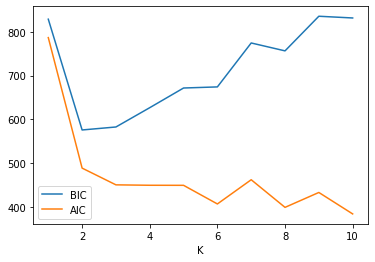

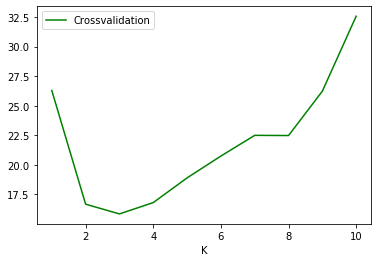

In [16]:
plt.figure(1)
# Plot results
plt.plot(KRange, BIC)
plt.plot(KRange, AIC)
plt.legend(['BIC', 'AIC'])
plt.xlabel('K')
plt.figure(2)
plt.plot(KRange, CVE,"green")
plt.legend(["Crossvalidation"])
plt.xlabel('K');

### 11.2 Density Estimation

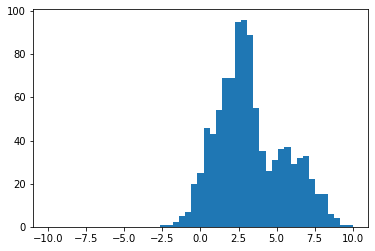

In [17]:
## Method 1

# Number of data objects
N = 1000

# Number of attributes
M = 1

# x-values to evaluate the histogram
x = np.linspace(-10, 10, 50)

# Allocate variable for data
X = np.empty((N,M))

# Mean and covariances
m = np.array([1, 3, 6])
s = np.array([1, .5, 2])

# Draw samples from mixture of gaussians
c_sizes = np.random.multinomial(N, [1./3, 1./3, 1./3])
for c_id, c_size in enumerate(c_sizes):
    X[c_sizes.cumsum()[c_id]-c_sizes[c_id]:c_sizes.cumsum()[c_id],:] = np.random.normal(m[c_id], np.sqrt(s[c_id]), (c_size,M))


# Plot histogram of sampled data
plt.figure()
plt.hist(X,x);


In [477]:
print(X.shape)

(1000, 1)


To define the bins at which the histogram should be evaluated, you can define a vector of values and pass it to hist. To get 50 bins evenly spaced between -10 and 10, you can use the command `x=np.linspace(-10,10,50)`.

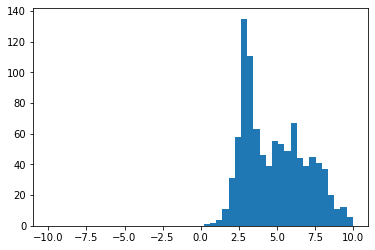

In [18]:
## Method 2
N=1000
X=np.zeros(N)

for t,n in enumerate(range(N)):
    selection=np.random.randint(1,4)
    if selection==1:
        X[t]=np.random.normal(1,1)
    if selection==2:
        X[t]=np.random.normal(3,0.5)
    else:
        X[t]=np.random.normal(6,2)
        
    
plt.hist(X,x);

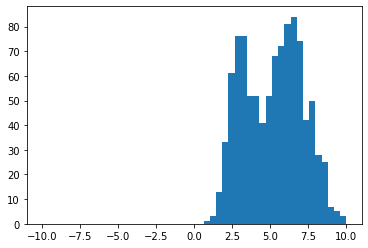

In [19]:
## Method 3
N=1000
X=np.zeros(N)

for t,n in enumerate(range(N)):
    size=np.random.multinomial(1, [1./3, 1./3, 1./3]).tolist()
    ind=size.index(1)
    if ind==0:
        X[t]=np.random.normal(1,1)
    if ind==1:
        X[t]=np.random.normal(3,np.sqrt(0.5))
    else:
        X[t]=np.random.normal(6,np.sqrt(2))
        
plt.hist(X,x);

#### Method 1:KDE 

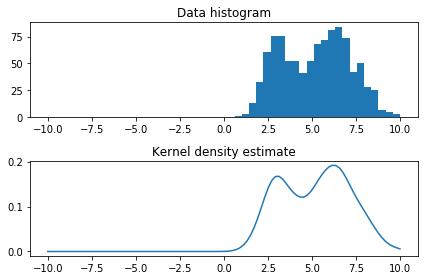

In [20]:
from scipy.stats.kde import gaussian_kde

# x-values to evaluate the KDE
xe = np.linspace(-10, 10, 100)

# Compute kernel density estimate
kde = gaussian_kde(X)

# Plot kernel density estimate
plt.figure()
plt.subplot(2,1,1)
plt.hist(X,x)
plt.title('Data histogram')
plt.subplot(2,1,2)
plt.plot(xe, kde.evaluate(xe))
plt.title('Kernel density estimate')
plt.tight_layout();



#### Method 2: KDE

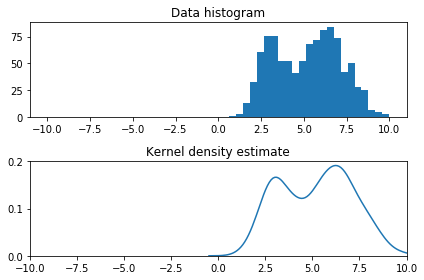

In [21]:
import seaborn as sns
plt.figure()
plt.subplot(2,1,1)
plt.hist(X,x)
plt.title('Data histogram')

plt.subplot(2,1,2)
sns.kdeplot(X, bw=0.5)
plt.xlim(-10,10)
plt.title('Kernel density estimate')
plt.tight_layout();


#### KDE and KNN

In [22]:
from sklearn.neighbors import NearestNeighbors

In [24]:
print(X.shape)
X=X.reshape(1,-1).T
# it must be (1000,1) not (1,1000)

# Number of neighbors
K = 200

# x-values to evaluate the KNN
xe = np.linspace(-10, 10, 100)

# Find the k nearest neighbors
knn = NearestNeighbors(n_neighbors=K)
knn.fit(X)

# Finds the K-neighbors of a point
D, i = knn.kneighbors(xe.reshape(-1,1))
## the shape of xe must be (100,1) not another way around
## D: distance 
## i: element
D.shape
## the first element in xe
print(xe[0])
# which means that the element is at distance 0.95595685 and is the 114th element of samples; 0.95595685
print(D[0,][0])
print(i[0,][0])
print(X[114])

(1000,)
-10.0
11.00394029528788
557
[6.03581868]


In [25]:
XE=["xe"+str(i) for i in range(1,len(xe)+1)]
Distance=["D"+str(i)for i in range(1,K+1)]
Dist_data=pd.DataFrame(D).set_axis(Distance,axis=1,inplace=False).set_index([pd.Index(XE)])
Dist_data.head(10)

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D191,D192,D193,D194,D195,D196,D197,D198,D199,D200
xe1,11.003940,11.156968,11.363862,11.367853,11.432525,11.462254,11.530191,11.628686,11.651074,11.676389,...,13.070557,13.073517,13.087355,13.088274,13.088824,13.094586,13.097732,13.103059,13.107087,13.112745
xe2,10.801920,10.954947,11.161842,11.165833,11.230504,11.260234,11.328171,11.426666,11.449053,11.474369,...,12.868537,12.871497,12.885335,12.886254,12.886803,12.892565,12.895712,12.901039,12.905066,12.910725
xe3,10.599900,10.752927,10.959822,10.963813,11.028484,11.058214,11.126150,11.224646,11.247033,11.272348,...,12.666517,12.669477,12.683314,12.684234,12.684783,12.690545,12.693692,12.699019,12.703046,12.708705
xe4,10.397880,10.550907,10.757802,10.761792,10.826464,10.856193,10.924130,11.022625,11.045013,11.070328,...,12.464497,12.467457,12.481294,12.482213,12.482763,12.488525,12.491671,12.496999,12.501026,12.506684
xe5,10.195859,10.348887,10.555781,10.559772,10.624444,10.654173,10.722110,10.820605,10.842993,10.868308,...,12.262476,12.265436,12.279274,12.280193,12.280743,12.286505,12.289651,12.294978,12.299006,12.304664
xe6,9.993839,10.146867,10.353761,10.357752,10.422424,10.452153,10.520090,10.618585,10.640973,10.666288,...,12.060456,12.063416,12.077254,12.078173,12.078723,12.084484,12.087631,12.092958,12.096986,12.102644
xe7,9.791819,9.944846,10.151741,10.155732,10.220403,10.250133,10.318070,10.416565,10.438952,10.464268,...,11.858436,11.861396,11.875234,11.876153,11.876702,11.882464,11.885611,11.890938,11.894965,11.900624
xe8,9.589799,9.742826,9.949721,9.953712,10.018383,10.048113,10.116049,10.214545,10.236932,10.262247,...,11.656416,11.659376,11.673213,11.674133,11.674682,11.680444,11.683591,11.688918,11.692945,11.698604
xe9,9.387779,9.540806,9.747701,9.751691,9.816363,9.846092,9.914029,10.012524,10.034912,10.060227,...,11.454395,11.457355,11.471193,11.472112,11.472662,11.478424,11.481570,11.486898,11.490925,11.496583
xe10,9.185758,9.338786,9.545680,9.549671,9.614343,9.644072,9.712009,9.810504,9.832892,9.858207,...,11.252375,11.255335,11.269173,11.270092,11.270642,11.276404,11.279550,11.284877,11.288905,11.294563


In [26]:
# Compute the density
#D, i = knclassifier.kneighbors(np.matrix(xe).T)
knn_density = 1./(D.sum(axis=1)/K)

# Compute the average relative density
DX, iX = knn.kneighbors(X)
print(DX.shape)
knn_densityX = 1./(DX[:,1:].sum(axis=1)/K)
knn_avg_rel_density = knn_density/(knn_densityX[i[:,1:]].sum(axis=1)/K)


(1000, 200)


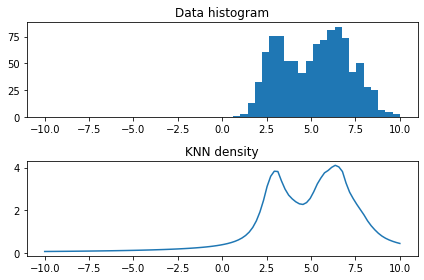

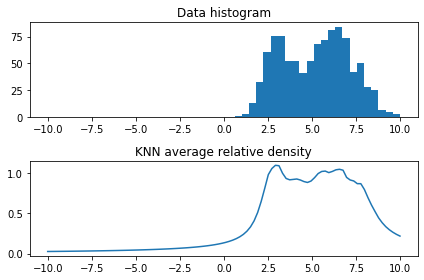

In [27]:

# Plot KNN density
plt.figure()
plt.subplot(2,1,1)
plt.hist(X,x)
plt.title('Data histogram')
plt.subplot(2,1,2)
plt.plot(xe, knn_density)
plt.title('KNN density')
plt.tight_layout()
# Plot KNN average relative density
plt.figure()
plt.subplot(2,1,1)
plt.hist(X,x)
plt.title('Data histogram')
plt.subplot(2,1,2)
plt.plot(xe, knn_avg_rel_density)
plt.title('KNN average relative density')
plt.tight_layout();

### 11.3 Outlier detection

In [59]:
import matplotlib.pyplot as plt
from scipy.stats.kde import gaussian_kde

N=1000
X=np.zeros(N)

for t,n in enumerate(range(N)):
    size=np.random.multinomial(1, [1./3, 1./3, 1./3]).tolist()
    ind=size.index(1)
    if ind==0:
        X[t]=np.random.normal(1,1)
    if ind==1:
        X[t]=np.random.normal(3,np.sqrt(0.5))
    else:
        X[t]=np.random.normal(6,np.sqrt(2))


X[0]=-10 # added outlier

The index of the lowest density object: 0


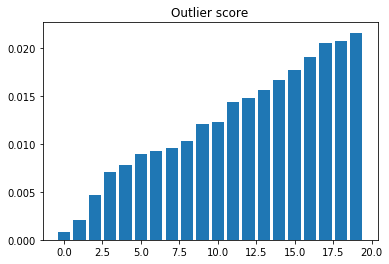

In [61]:
# Compute kernel density estimate
kde = gaussian_kde(X)
scores = kde.evaluate(X)
idx = scores.argsort()
scores.sort()

print('The index of the lowest density object: {0}'.format(idx[0]))

# Plot kernel density estimate
plt.figure()
## the first 20
plt.bar(range(20),scores[:20])
plt.title('Outlier score')
plt.show()


- Can the outlier be detected from this plot?
- Try different values of the kernel width.
- What happens when the kernel width is too large / too small?

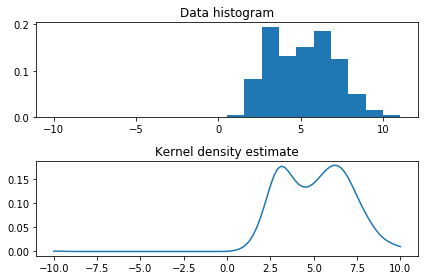

In [82]:
# n the number of data points and d the number of dimensions
n=len(X)
d=1
## Scott’s Rule for bandwidth
bandwidth=n**(-1./(d+4))
## Silverman’s Rule
bandwidth= (n * (d + 2) / 4.)**(-1. / (d + 4))

kde = gaussian_kde(X,bw_method=bandwidth)
# Plot kernel density estimate

plt.figure()
plt.subplot(2,1,1)
plt.hist(X,bins=20,density=True)
plt.title('Data histogram')
xe = np.linspace(-10, 10, 100)
plt.subplot(2,1,2)
plt.plot(xe, kde.evaluate(xe))
plt.title('Kernel density estimate')
plt.tight_layout();

In [83]:
from toolbox_02450 import gausKernelDensity

In [100]:
# Estimate the optimal kernel density width, by leave-one-out cross-validation
widths = 2.0**np.arange(-10,10)
logP = np.zeros(np.size(widths))
for i,w in enumerate(widths):
    f, log_f = gausKernelDensity(X.reshape(-1,1), w)
    logP[i] = log_f.sum()
val = logP.max()
ind = logP.argmax()

width=widths[ind]
print('Optimal estimated width is: {0}'.format(width))

# Estimate density for each observation not including the observation
# itself in the density estimate
density, log_density = gausKernelDensity(X.reshape(-1,1), width)

Optimal estimated width is: 1.0


In [106]:
widths = 2.0**np.arange(-10,10)

array([9.765625e-04, 1.953125e-03, 3.906250e-03, 7.812500e-03,
       1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
       2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
       4.000000e+00, 8.000000e+00, 1.600000e+01, 3.200000e+01,
       6.400000e+01, 1.280000e+02, 2.560000e+02, 5.120000e+02])

Lowest density: [1.10112318e-29] for data object: 0


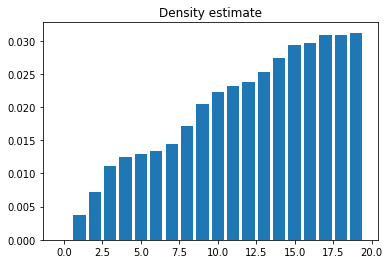

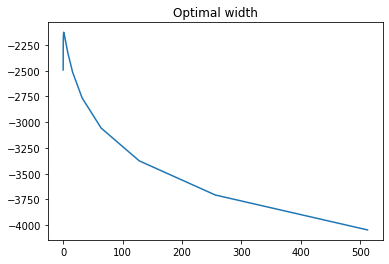

In [113]:
# Sort the densities
i = (density.argsort(axis=0)).ravel()
density = density[i]

# Display the index of the lowest density data object
print('Lowest density: {0} for data object: {1}'.format(density[0],i[0]))

# Plot density estimate of outlier score
plt.figure(1)
plt.bar(range(20),density.flatten()[:20])
plt.title('Density estimate')
plt.figure(2)
widths = 2.0**np.arange(-10,10)
plt.plot(widths,logP)
plt.title('Optimal width')
plt.show()



### Kernel Density Multivariate Gaussian

In [116]:
 # Set sample parameters
np.random.seed(0)
n = 2010
d = 3

# Generate data
X = np.zeros((n, d))
X[:1000,0] = 5
X[1000:2000,0] = -5
X += 0.01*np.random.randn(*X.shape)
X.shape

(2010, 3)

In [145]:
## dataset: Datapoints to estimate from. In case of univariate data this is a 1-D array, 
## otherwise a 2-D array with shape (# of dims, # of data).
kde = gaussian_kde(dataset=X.T)
scores = kde.evaluate(X.T)
idx = scores.argsort()
scores.sort()

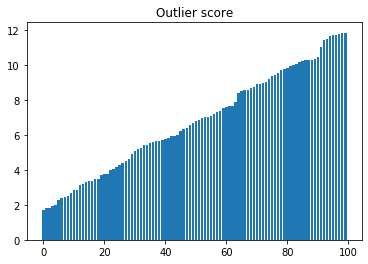

In [146]:
# Plot kernel density estimate
plt.figure()
## the first 20
plt.bar(range(100),scores[:100])
plt.title('Outlier score')
plt.show()

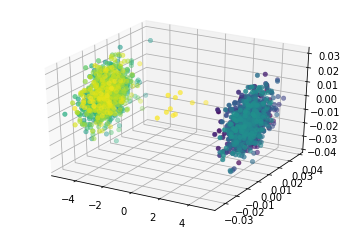

In [147]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=scores, cmap='viridis', linewidth=0.5);

In [ ]:
### Kernel density KNN

In [155]:
# Find the k nearest neighbors
K=200
knn = NearestNeighbors(n_neighbors=K)
knn.fit(X)

# Compute the average relative density
DX, iX = knn.kneighbors(X)
print(DX.shape)

knn_densityX = 1./(DX[:,1:].sum(axis=1)/K)
knn_avg_rel_density = knn_density/(knn_densityX[i[:,1:]].sum(axis=1)/K)

(2010, 200)


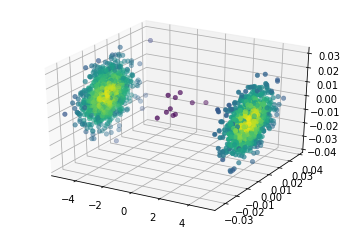

In [156]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=knn_densityX, cmap='viridis', linewidth=0.5);

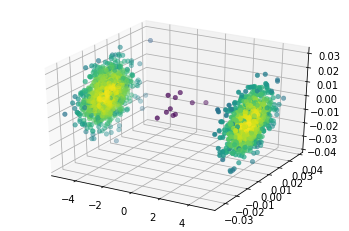

In [158]:
ax = plt.axes(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=knn_avg_rel_density, cmap='viridis', linewidth=0.5);

## Hand written digits

In [159]:
from scipy.io import loadmat
from toolbox_02450 import gausKernelDensity
from sklearn.neighbors import NearestNeighbors

# load data from Matlab data file
matdata = loadmat('digits.mat')
X = np.matrix(matdata['X'])
y = np.matrix(matdata['y'])
N, M = np.shape(X)

# Restrict the data to images of "2"
X = X[y.A.ravel()==2,:]
N, M = np.shape(X)

In [163]:
### Gausian Kernel density estimator
# cross-validate kernel width by leave-one-out-cross-validation
# (efficient implementation in gausKernelDensity function)
# evaluate for range of kernel widths
widths = X.var(axis=0).max() * (2.0**np.arange(-10,3))
logP = np.zeros(np.size(widths))
for i,w in enumerate(widths):
    density, log_density = gausKernelDensity(X,w)
    logP[i] = log_density.sum()
val = logP.max()
ind = logP.argmax()

width=widths[ind]
print('Optimal estimated width is: {0}'.format(width))

Optimal estimated width is: 0.19422718071215705


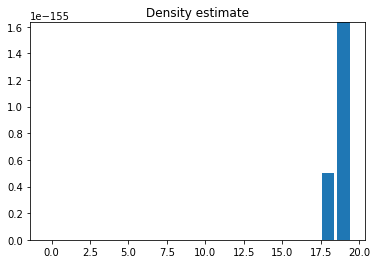

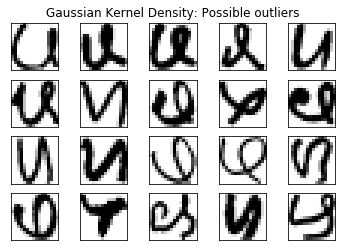

In [171]:
# evaluate density for estimated width
density, log_density = gausKernelDensity(X,width)

# Sort the densities
i = (density.argsort(axis=0)).ravel()
density = density[i]

# Plot density estimate of outlier score
plt.figure(1)
plt.bar(range(20),density.flatten()[:20])
plt.title('Density estimate')

# Plot possible outliers
plt.figure(2)
for k in range(1,21):
    plt.subplot(4,5,k)
    plt.imshow(np.reshape(X[i[k],:], (16,16)).T, cmap="binary")
    plt.xticks([]); plt.yticks([])
    if k==3: plt.title('Gaussian Kernel Density: Possible outliers')

In [174]:
### K-neighbors density estimator
# Neighbor to use:
K = 5

# Find the k nearest neighbors
knn = NearestNeighbors(n_neighbors=K).fit(X)
D, i = knn.kneighbors(X)

density = 1./(D.sum(axis=1)/K)

# Sort the scores
i = density.argsort()
density = density[i]

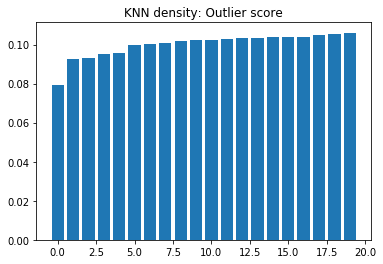

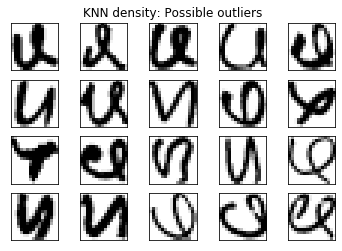

In [176]:
# Plot k-neighbor estimate of outlier score (distances)
plt.figure(3)
plt.bar(range(20),density[:20])
plt.title('KNN density: Outlier score')
# Plot possible outliers
plt.figure(4)
for k in range(1,21):
    plt.subplot(4,5,k)
    plt.imshow(np.reshape(X[i[k],:], (16,16)).T, cmap="binary")
    plt.xticks([]); plt.yticks([])
    if k==3: plt.title('KNN density: Possible outliers')

In [177]:
### K-nearest neigbor average relative density
# Compute the average relative density
knn = NearestNeighbors(n_neighbors=K).fit(X)
D, i = knn.kneighbors(X)
density = 1./(D.sum(axis=1)/K)
avg_rel_density = density/(density[i[:,1:]].sum(axis=1)/K)

# Sort the avg.rel.densities
i_avg_rel = avg_rel_density.argsort()
avg_rel_density = avg_rel_density[i_avg_rel]

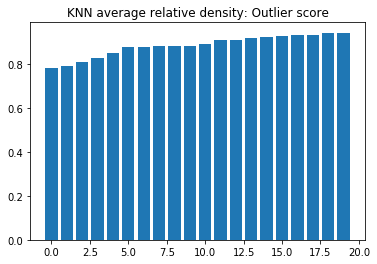

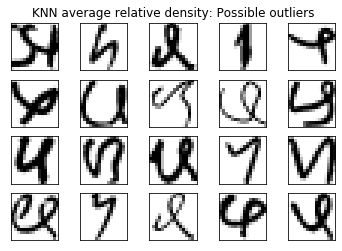

In [178]:
# Plot k-neighbor estimate of outlier score (distances)
plt.figure(5)
plt.bar(range(20),avg_rel_density[:20])
plt.title('KNN average relative density: Outlier score')
# Plot possible outliers
plt.figure(6)
for k in range(1,21):
    plt.subplot(4,5,k)
    plt.imshow(np.reshape(X[i_avg_rel[k],:], (16,16)).T, cmap="binary")
    plt.xticks([]); plt.yticks([])
    if k==3: plt.title('KNN average relative density: Possible outliers')

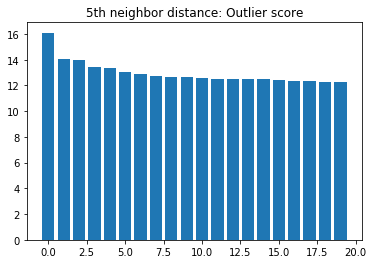

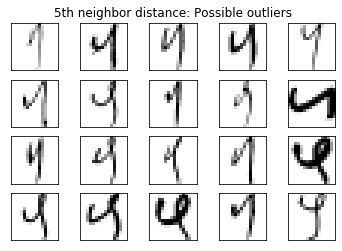

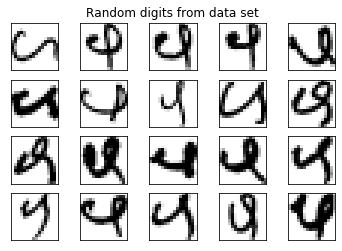

In [183]:
## Distance to 5'th nearest neighbor outlier score
K = 5

# Find the k nearest neighbors
knn = NearestNeighbors(n_neighbors=K).fit(X)
D, i = knn.kneighbors(X)

# Outlier score
score = D[:,K-1]
# Sort the scores
i = score.argsort()
score = score[i[::-1]]

# Plot k-neighbor estimate of outlier score (distances)
plt.figure(7)
plt.bar(range(20),score[:20])
plt.title('5th neighbor distance: Outlier score')
# Plot possible outliers
plt.figure(8)
for k in range(1,21):
    plt.subplot(4,5,k)
    plt.imshow(np.reshape(X[i[k],:], (16,16)).T, cmap="binary"); 
    plt.xticks([]); plt.yticks([])
    if k==3: plt.title('5th neighbor distance: Possible outliers')

# Plot random digits (the first 20 in the data set), for comparison
plt.figure(9)
for k in range(1,21):
    plt.subplot(4,5,k);
    plt.imshow(np.reshape(X[k,:], (16,16)).T, cmap="binary"); 
    plt.xticks([]); plt.yticks([])
    if k==3: plt.title('Random digits from data set')    

plt.show()